In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Dense, Activation
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import adam_v2
from tensorflow.keras.utils import to_categorical
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the csv files over here into pandas data frame
# YOUR CODE HERE
# 0.1
def load_csv(file_name):
  # Input: csv_file_name
  # Output: pandas data frame
    data = pd.read_csv(file_name)
    print(data.info())
    return data

In [90]:
data = load_csv('data_2-1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   3129 non-null   int64  
 1   HR                   3020 non-null   float64
 2   interval in seconds  3129 non-null   float64
 3   NNRR                 3071 non-null   float64
 4   AVNN                 3055 non-null   float64
 5   SDNN                 3039 non-null   float64
 6   RMSSD                3129 non-null   float64
 7   pNN50                3129 non-null   float64
 8   TP                   2910 non-null   float64
 9   ULF                  3006 non-null   float64
 10  VLF                  3033 non-null   float64
 11  LF                   3033 non-null   float64
 12  HF                   3033 non-null   float64
 13  LF_HF                48 non-null     float64
 14  stress               3129 non-null   float64
dtypes: float64(14), int64(1)
memory usage:

# Part 1 - Data cleaning, normalization and missing value fillup

In [92]:
def missing_filler1(df):
  # Take input the raw data and fillup the missing values using first algorithm.
  # YOUR CODE HERE
    df_re = pd.DataFrame()
    if 'stress' in df.columns:
        for i in set(df['stress']):
            df_i = df.where(df['stress'] == i)
            df_i = df_i.replace(np.inf, np.nan)
            df_i = df_i.dropna(axis=0,how='all')
            df_i = df_i.fillna(df_i.mean())
            df_re = pd.concat([df_re,df_i],axis = 0)
    else:
            df_i = df.replace(np.inf, np.nan)
            df_i = df_i.dropna(axis=0,how='all')
            df_i = df_i.fillna(df_i.mean())
            df_re = pd.concat([df_re,df_i],axis = 0)
    return df_re

In [93]:
def missing_filler2(df):
  # Take input the raw data and fillup the missing values using first algorithm.
  # YOUR CODE HERE
    df_re = pd.DataFrame()
    if 'stress' in df.columns:
        for i in set(df['stress']):
            df_i = df.where(df['stress'] == i)
            df_i = df_i.replace(np.inf, np.nan)
            df_i = df_i.dropna(axis=0,how='all')
            df_i = df_i.interpolate() 
            df_i = df_i.fillna(df_i.mean())
            df_re = pd.concat([df_re,df_i],axis = 0)
    else:
            df_i = df.replace(np.inf, np.nan)
            df_i = df_i.dropna(axis=0,how='all')
            df_i = df_i.interpolate() 
            df_i = df_i.fillna(df_i.mean())
            df_re = pd.concat([df_re,df_i],axis = 0)
    return df_re

In [94]:
def cleaning(df):
  # Take all the features as input, and do any data cleaning necessary.
  # YOUR CODE HERE
    df_re = pd.DataFrame()
    df = df.drop('Id',axis = 1)
    #data_ = data_[(np.abs(stats.zscore(data_))<3).all(axis = 1)]
    if 'stress' in df.columns:
        for i in set(df['stress']):
            df_i = df.where(df['stress'] == i)
            df_i = df_i.dropna(axis=0,how='all')
            for i in df_i.columns:
                if df_i.count()[i] < len(df_i)*0.2:
                    del df_i[i]
            df_re = pd.concat([df_re,df_i],axis = 0)
    else:
        for i in df.columns:
            if df.count()[i] < len(df)*0.2:
                del df[i]
        df_re = pd.concat([df_re,df],axis = 0)
    return df_re

In [95]:
def normalizer(df):
  # Taken input the output of cleaning function, 
  #and perform data normalization independently for all the features.
  # YOUR CODE HERE
    data_std = df.copy()
    std = StandardScaler()
    if 'stress' in df.columns:
        for col in df.columns.drop('stress'):
            data_std[col] = std.fit_transform(data_std[col].values.reshape(-1,1))
    else:
        for col in df.columns:
            data_std[col] = std.fit_transform(data_std[col].values.reshape(-1,1))
    return data_std

In [96]:
data1 = cleaning(data)
data1 = missing_filler2(data1)
data1 = normalizer(data1)
data1

,HR,interval in seconds,NNRR,AVNN,SDNN,RMSSD,pNN50,TP,ULF,VLF,LF,HF,stress
0,1.305989,-1.285923,1.346949,-1.296620,-1.669851,-1.610495,-1.369549,-0.009374,-0.948111,-0.006073,0.068880,0.042274,0.0
1,0.276921,-1.298530,1.346949,-1.296620,-1.669851,-1.610495,-1.369549,-0.009374,-0.948111,-0.006073,0.068880,0.042274,0.0
2,0.344172,-1.298530,1.346949,-1.296620,-1.669851,-1.610495,-1.369549,-0.009374,-0.948111,-0.006073,0.068880,0.042274,0.0
3,0.497708,-1.298530,1.346949,-1.296620,-1.669851,-1.610495,-1.369549,-0.009374,-0.948111,-0.006073,0.068880,0.042274,0.0
4,0.481354,-1.208366,1.159974,-1.204084,-0.967631,-1.030283,-0.463398,-0.952790,-0.948111,-0.159366,5.072979,1.450954,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3071,-0.164525,-0.062251,-0.159776,-0.059917,-0.122519,-0.121686,-0.320323,-0.303772,-0.289243,-0.229110,-0.200357,-0.189888,2.0
3072,-0.285291,-0.062251,-0.159776,-0.059917,-0.122519,-0.121686,-0.320323,-0.311961,-0.297438,-0.229110,-0.200357,-0.189888,2.0
3073,0.160154,-0.589647,0.546033,-0.587114,-0.819685,-0.796746,-0.397097,-0.751806,-0.737600,-0.229110,-0.200357,-0.189888,2.0
3074,0.248917,-0.589647,0.546033,-0.587114,-0.819685,-0.796746,-0.397097,-0.751248,-0.737043,-0.229110,-0.200357,-0.189888,2.0


# Part 2 - Model training and testing

In [10]:
# Splitting the dataset into train, val and test sets.
# 2.0
X = np.array(data1.drop(['stress'],axis = 1))
y = np.array(data1['stress'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [45]:
# Code for different models used.

def decisiontree(X_train,y_train,X_test,y_test):
  # You can use the sci-kit learn solver but capture any other hyper-parameter settings
  # or model settings in this method
  # YOUR CODE HERE
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6,min_weight_fraction_leaf=0.001)
    clf = clf.fit(X_train,y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print('Decision Tree')
    print('train score:', accuracy_score(y_train, y_train_pred))
    print('test score:', accuracy_score(y_test, y_test_pred))
    return y_train_pred, clf

def logisticregression(X_train,y_train,X_test,y_test):
  # You can use the sci-kit learn solver but capture any other hyper-parameter settings
  # or model settings in this method
  # YOUR CODE HERE
    lr = LogisticRegression(tol = 1e-5,max_iter = 150)
    lr.fit(X_train,y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    print('Logistic Regression')
    print('train score:', accuracy_score(y_train, y_train_pred))
    print('test score:', accuracy_score(y_test, y_test_pred))
    return y_train_pred,lr

def randomforest(X_train, y_train,X_test,y_test):
  # You can use the sci-kit learn solver but capture any other hyper-parameter settings
  # or model settings in this method
  # YOUR CODE HERE
    acc = 0
    model = None
    rf = RandomForestClassifier(
         criterion='entropy',
            n_estimators=54, 
            max_depth=47,
            min_weight_fraction_leaf=0.005
            )

    rf.fit(X_train, y_train)
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    print('Random Forest')
    print('train score:', accuracy_score(y_train, y_train_pred))
    print('test score:', accuracy_score(y_test, y_test_pred))
    return y_train_pred,rf

def MLP(X_train, y_train,X_test,y_test):
    mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=25000)
    mlp.fit(X_train, y_train)
    y_train_pred = mlp.predict(X_train)
    y_test_pred = mlp.predict(X_test)
    print('MLP')
    print('train score:', accuracy_score(y_train, y_train_pred))
    print('test score:', accuracy_score(y_test, y_test_pred))
    return y_train_pred,mlp

def NN(X_train, y_train,X_test,y_test):
    y_train_c = to_categorical(y_train)
    y_test_c = to_categorical(y_test)

    model = Sequential()
    model.add(Dense(10, input_shape=(X_train.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(y_train_c.shape[1]))
    model.add(Activation('softmax'))
    model.compile(adam_v2.Adam(), categorical_crossentropy, ['accuracy'])

    model.fit(X_train, y_train_c, batch_size=128, epochs=5000, verbose=0)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    #eval_on_show(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred)
    y_train_pred_1 = [i.index(max(i)) for i in y_train_pred.tolist()]
    y_test_pred_1 = [i.index(max(i)) for i in y_test_pred.tolist()]
    print('Neural Network')
    print('train score:', accuracy_score(y_train, y_train_pred_1))
    print('test score:', accuracy_score(y_test, y_test_pred_1))
    return y_train_pred_1,model
# Please also rename the model functions to reflect what it represents.
# Discuss about the hyper-parameter/model settings in the report.

In [78]:
# GridSearch
estimator=  RandomForestClassifier(criterion='entropy',
                                    min_weight_fraction_leaf=0.005)
param_grid = {'max_depth': range(10,100),
              'n_estimators': range(50,100)}

gbm = GridSearchCV(estimator, param_grid)
gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

Best parameters found by grid search are: {'max_depth': 47, 'n_estimators': 54}


In [87]:
y_pred_lr,LR_model = logisticregression(X_train,y_train,X_test,y_test)
y_pred_RF,RF_model = randomforest(X_train,y_train,X_test,y_test)
y_pred_DT,DT_model = decisiontree(X_train,y_train,X_test,y_test)

Logistic Regression
train score: 0.491410307630843
test score: 0.4424920127795527
Random Forest
train score: 0.6388333999200959
test score: 0.5095846645367412
Decision Tree
train score: 0.564522572912505
test score: 0.49201277955271566


In [13]:
# Create function which calculates F1score, precision, recall and accuracy score for true and predicted labels.
def metrics(y_pred, y_test,name):

  # Takes input the predicted and true labels.
  # Your code here for precision, recall, F1score, accuracy
  # You can call this code to compute metrics for your models
    con_matrix = confusion_matrix(y_test, y_pred)
    cla_report = classification_report(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
    f1_score_ = f1_score(y_test, y_pred,average='weighted')
    print(name)
    print('confusion_matrix:')
    print(con_matrix)
    print('---------------------------------')
    print('classification_report:')
    print(cla_report)
    print('---------------------------------')
    print('accuracy_score:')
    print(acc_score)
    print('---------------------------------')
    print('f1_score:')
    print(f1_score_)    

In [42]:
metrics(y_pred_lr, y_train,'Logistic Regression')

Logistic Regression
confusion_matrix:
[[ 310  361   14]
 [ 117 1067   29]
 [  33  526   46]]
---------------------------------
classification_report:
              precision    recall  f1-score   support

         0.0       0.67      0.45      0.54       685
         1.0       0.55      0.88      0.67      1213
         2.0       0.52      0.08      0.13       605

    accuracy                           0.57      2503
   macro avg       0.58      0.47      0.45      2503
weighted avg       0.57      0.57      0.51      2503

---------------------------------
accuracy_score:
0.5685177786656013
---------------------------------
f1_score:
0.5067786811038061


In [47]:
metrics(y_pred_lr, y_train,'Decision Tree')

Decision Tree
confusion_matrix:
[[ 310  361   14]
 [ 117 1067   29]
 [  33  526   46]]
---------------------------------
classification_report:
              precision    recall  f1-score   support

         0.0       0.67      0.45      0.54       685
         1.0       0.55      0.88      0.67      1213
         2.0       0.52      0.08      0.13       605

    accuracy                           0.57      2503
   macro avg       0.58      0.47      0.45      2503
weighted avg       0.57      0.57      0.51      2503

---------------------------------
accuracy_score:
0.5685177786656013
---------------------------------
f1_score:
0.5067786811038061


In [43]:
metrics(y_pred_RF, y_train,'Random Forest')

Random Forest
confusion_matrix:
[[ 459  208   18]
 [  77 1060   76]
 [  24  332  249]]
---------------------------------
classification_report:
              precision    recall  f1-score   support

         0.0       0.82      0.67      0.74       685
         1.0       0.66      0.87      0.75      1213
         2.0       0.73      0.41      0.53       605

    accuracy                           0.71      2503
   macro avg       0.74      0.65      0.67      2503
weighted avg       0.72      0.71      0.69      2503

---------------------------------
accuracy_score:
0.706352377147423
---------------------------------
f1_score:
0.6939954927655633


In [77]:
# Kaggle Prediction
data_kaggle = pd.read_csv('kaggle_2.csv')
data_kaggle = cleaning(data_kaggle)
data_kaggle = missing_filler1(data_kaggle)
data_kaggle = normalizer(data_kaggle)
X_kaggle = np.array(data_kaggle)
y_kaggle = RF_model.predict(X_kaggle)
#y_kaggle = [float(i.index(max(i))) for i in y_kaggle.tolist()]
out_file = pd.DataFrame(range(0,1000),columns = ['Id'])
out_file['stress'] = y_kaggle
out_file['stress'].astype(float)

out_file.to_csv('result.csv',index = False)

# Part 3 - Interpretability

In [34]:
X = np.array(data1.drop(['stress'],axis = 1))
y = np.array(data1['stress'])

In [50]:
# Look into using suitable functions from sklearn. Explain your code and findings clearly in the report document.
# YOUR CODE HERE
# 3.1

def FeatureImportance(X,y,dataset,k,d_type='ETC'): # d_type:'ETC' or 'MIC'
  # Your code can based on measures of information gain or other feature selection methods
  # Input: k - Number of features to pick
  # Output should be a ranked list of features
    d = {}
    if d_type == 'MIC':
        result = mutual_info_classif(X, y, discrete_features= False)
    elif d_type == 'ETC':
        forest = ExtraTreesClassifier(n_estimators=250, random_state=0).fit(X,y)
        result = forest.feature_importances_
    else:
        return False
    
    dataset = list(dataset.columns)
    dataset.remove('stress')
    
    for i in range(len(X[1])):
        d[dataset[i]] = result[i]
    re = sorted(d.items(),key = lambda v:v[1])
    re.reverse()
    
    if k > len(X[1]): 
        k = len(X[1])
    if not k:
        return False
    
    indices = np.argsort(result)[::-1]
    plt.bar(range(12), result[indices])
    plt.xticks(range(X.shape[1]), [dataset[i] for i in indices])
    plt.show()
    
    return re[:k]


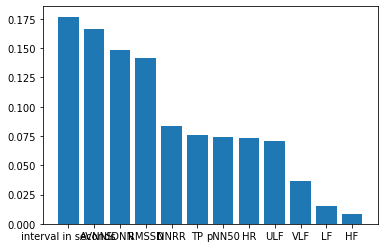

[('interval in seconds', 0.1769182973291652),
 ('AVNN', 0.16680977435470923),
 ('SDNN', 0.14888458544810512),
 ('RMSSD', 0.14199441513463085),
 ('NNRR', 0.0834642629323572)]

In [51]:
FeatureImportance(X,y,data1,k = 5,d_type='MIC')

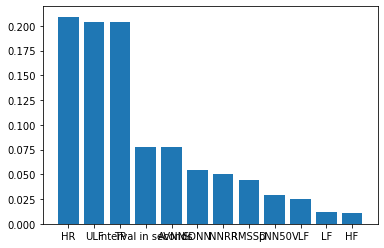

[('HR', 0.20930905840371986),
 ('ULF', 0.20439928666654184),
 ('TP', 0.20429202860938592),
 ('interval in seconds', 0.0777850301111131),
 ('AVNN', 0.07774884755478108)]

In [52]:
FeatureImportance(X,y,data1,k = 5,d_type='ETC')

In [51]:
def FeatureImportanceForPairs(model):
  # Find the best pairs of features which are useful for making the prediction.
  # HINT: Can be done in a model agnostic way through pair generation and ranking.
  # YOUR CODE HERE
    perm = PermutationImportance(model).fit(X_test, y_test)
    print('feature importances:',perm.feature_importances_)
    print('feature importances std:',perm.feature_importances_std_)
    return eli5.show_weights(perm,feature_names=data1.columns.drop('stress').tolist())

FeatureImportanceForPairs(RF_model)

feature importances: [ 0.04792332  0.03738019  0.00415335  0.03769968  0.02779553  0.01501597
  0.00319489  0.02939297  0.0284345  -0.0086262   0.00095847 -0.00255591]
feature importances std: [0.0109748  0.01013339 0.00511182 0.01003215 0.00411633 0.00576852
 0.0049495  0.00594284 0.00592563 0.00127796 0.00162908 0.00127796]


Weight,Feature
0.0479 ± 0.0219,HR
0.0377 ± 0.0201,AVNN
0.0374 ± 0.0203,interval in seconds
0.0294 ± 0.0119,TP
0.0284 ± 0.0119,ULF
0.0278 ± 0.0082,SDNN
0.0150 ± 0.0115,RMSSD
0.0042 ± 0.0102,NNRR
0.0032 ± 0.0099,pNN50
0.0010 ± 0.0033,LF


In [97]:
top5 = ['HR','AVNN','interval in seconds','TP','ULF']
while top5:
    for i in top5:
        top5.remove(i)
        for j in top5:
            data_tem = data1[i] + data1[j]
            X_tem = np.array(data_tem)
            y_tem = np.array(data1['stress'])
            X_train_tem, X_test_tem, y_train_tem, y_test_tem = train_test_split(X, y, test_size = 0.2)
            print('Feature Pair:',i,j)
            randomforest(X_train_tem,y_train_tem,X_test_tem,y_test_tem)
            print('----------------------------------')

Feature Pair: HR AVNN
Random Forest
train score: 0.6404314822213344
test score: 0.5111821086261981
----------------------------------
Feature Pair: HR interval in seconds
Random Forest
train score: 0.6308429884139033
test score: 0.5271565495207667
----------------------------------
Feature Pair: HR TP
Random Forest
train score: 0.630043947263284
test score: 0.5447284345047924
----------------------------------
Feature Pair: HR ULF
Random Forest
train score: 0.6448262085497403
test score: 0.5207667731629393
----------------------------------
Feature Pair: interval in seconds AVNN
Random Forest
train score: 0.6456252497003596
test score: 0.5159744408945687
----------------------------------
Feature Pair: interval in seconds TP
Random Forest
train score: 0.6372353176188573
test score: 0.5527156549520766
----------------------------------
Feature Pair: interval in seconds ULF
Random Forest
train score: 0.6256492209348782
test score: 0.5670926517571885
----------------------------------
Fea